In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2,f_classif
import seaborn as sns
import matplotlib.pyplot as plt
import  string
from string import *
import sklearn
from sklearn.model_selection import  train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,roc_curve,precision_score,recall_score,auc,precision_recall_curve

## Index
* [Load and process data](#load-and-process-data)
* [Question 1](#question-1)
* [Question 2](#question-2)
    * [Visualization of purhases](#Visualization-of-`purhases`)
    * [Visualization of country](#Visualization-of-`country`)
    * [Visualization of is_personal](#Visualization-of-`is_personal`)
    * [Visualization of weekday](#Visualization-of-`weekday`)
    * [Visualization of hour](#Visualization-of-`hour`)
    * [Visualization of paragraph](#Visualization-of-`paragraph`)
    * [Visualization of weekday&hour](#Visualization-of-`weekday&hour`)
* [Question 3](#question-3)
    * [Model](#XGBoost)
* [Question 4](#question-4)

## load and process data

In [2]:
emails=pd.read_csv(r"D:\data\email_table.csv",index_col="email_id")

Columns:
* email_id : the Id of the email that was sent. It is unique by email 
* email_text : there are two versions of the email: one has "long text" (i.e. has 4 paragraphs) and one has "short text" (just 2 paragraphs) 
* email_version : some emails were "personalized" (i.e. they had the name of the user receiving the email in the incipit, such as "Hi John,"), while some emails were "generic" (the incipit was just "Hi,"). 
* hour : the user local time when the email was sent. 
* weekday : the day when the email was sent. 
* user_country : the country where the user receiving the email was based. It comes from the user ip address when she created the account. 
* user_past_purchases : how many items in the past were bought by the user receiving the email

In [3]:
emails.sample(10)

,email_text,email_version,hour,weekday,user_country,user_past_purchases
email_id,,,,,,
583654,short_email,personalized,18,Tuesday,US,2
174062,long_email,generic,3,Monday,ES,1
932884,long_email,generic,8,Friday,UK,2
640870,short_email,generic,5,Monday,US,3
551977,short_email,personalized,14,Tuesday,US,3
768600,short_email,personalized,10,Friday,US,5
957480,short_email,generic,12,Wednesday,US,8
120313,short_email,personalized,7,Friday,UK,1
791566,short_email,personalized,18,Wednesday,FR,0


In [4]:
#查看缺失情况
emails.isnull().sum()

email_text             0
email_version          0
hour                   0
weekday                0
user_country           0
user_past_purchases    0
dtype: int64

In [5]:
#检验数据取值情况,没有错写等问题
ca_feature=list(emails.select_dtypes(include=['object']).columns)
for i in ca_feature:
    print(i)
    print(set(emails[i]))

email_text
{'short_email', 'long_email'}
email_version
{'generic', 'personalized'}
weekday
{'Thursday', 'Sunday', 'Wednesday', 'Monday', 'Tuesday', 'Saturday', 'Friday'}
user_country
{'FR', 'UK', 'US', 'ES'}


In [6]:
# 将取值具有大小意义的类别型变量数据转变为数值型映射
emails['paragraph']=np.where(emails.email_text=='short_email',2,4)
del emails['email_text']

emails['weekday']=emails.weekday.map({"Monday":1,"Tuesday":2,"Wednesday":3,
                                      "Thursday":4,"Friday":5,"Saturday":6,"Sunday":7})

emails["is_personal"] = (emails.email_version == "personalized").astype(np.int_)
del emails["email_version"]

emails.rename(columns={'user_past_purchases':'purchases','user_country':'country'},inplace=True)

In [7]:
emails['response']='recived'

open_users = pd.read_csv(r"D:\data\email_opened_table.csv").email_id
emails.loc[open_users,"response"] = "opened"

click_users = pd.read_csv(r"D:\data\link_clicked_table.csv").email_id
emails.loc[click_users,"response"] = "clicked"

In [8]:
emails.sample(10)

,hour,weekday,country,purchases,paragraph,is_personal,response
email_id,,,,,,,
580370,9,5,US,7,2,0,recived
310335,9,1,US,0,4,1,recived
409716,5,6,ES,5,4,0,recived
481894,4,5,US,8,4,1,recived
323778,7,7,US,1,2,0,recived
138414,8,5,UK,8,2,0,recived
62823,18,1,FR,8,4,0,recived
561766,12,5,US,4,4,0,recived
39530,5,5,UK,8,2,0,recived


In [9]:
emails.to_csv(r"D:\data\clean_emails.csv",index_label="email_id")

## question 1
* <span style='color:blue;font-weight:bold'>What percentage of users opened the email?</span>
* <span style='color:blue;font-weight:bold'>what percentage clicked on the link within the email?</span>

In [10]:
print('{0:25s} {1:>8.4f}%'.format('Opened user percentage:', len(open_users)/len(emails) * 100))
print('{0:25s} {1:>8.4f}%'.format('Clicked user percentage:', len(click_users)/len(emails) * 100))

Opened user percentage:    10.3450%
Clicked user percentage:    2.1190%


## question 2
* <span style='color:blue;font-weight:bold'>interesting pattern on how the email campaign performed for diﬀerent segments of users</span>

### Visualization of `purhases`

In [11]:
def count_result_ratio(df):
    counts = df.response.value_counts(normalize=True)
    counts['total'] = df.shape[0]
    return counts

def grp_count_plotbar(key):
    grpresult = emails.groupby(key).apply(count_result_ratio)
    fig = plt.figure(figsize=(10,7))
    data=grpresult.loc[:,['clicked']].sort_values(by='clicked',ascending=False)
    sns.barplot(data=data.T, palette = "Set1")
    plt.xlabel('{}'.format(str.capitalize(key)))
    plt.ylabel("Click Ratio")
    plt.title('Click ratio vs. {}'.format(str.capitalize(key)))
    return grpresult

In [12]:
grpby_purchase = emails.groupby("purchases").apply(count_result_ratio).unstack()
grpby_purchase.fillna(value=0,inplace=True)

Text(0.5, 1.0, 'Click Ratio vs Purchase')

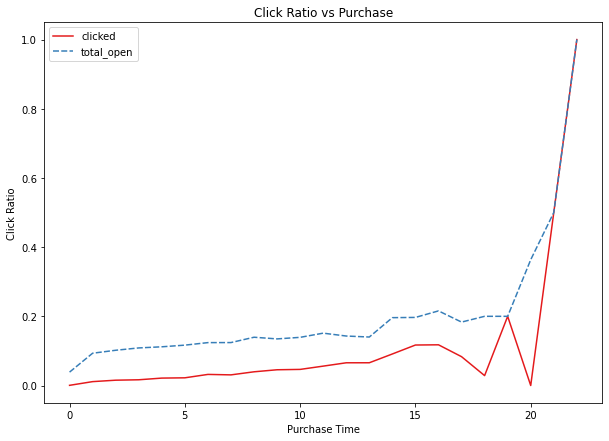

In [13]:
fig = plt.figure(figsize=(10,7))
grpby_purchase['total_open']=grpby_purchase['opened']+grpby_purchase['clicked']
sns.lineplot(data=grpby_purchase.drop(['total','recived','opened'],axis=1),palette="Set1")
plt.xlabel("Purchase Time")
plt.ylabel("Click Ratio")
plt.title("Click Ratio vs Purchase")

<span style='color:orange;font-weight:bold;font-size:1.2em'>总体来看，以往消费次数越多的消费者，越容易打开邮件和点击连接

### Visualization of `country`

response,recived,opened,clicked,total
country,,,,
ES,0.960570,0.031103,0.008327,9967.0
FR,0.958779,0.033217,0.008004,9995.0
UK,0.879282,0.096043,0.024675,19939.0
US,0.880481,0.095160,0.024360,60099.0


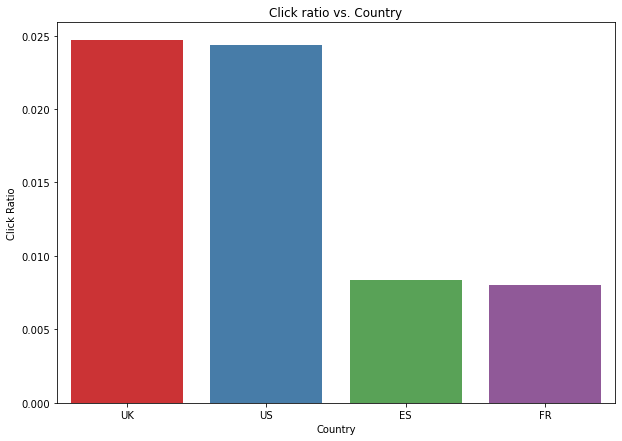

In [14]:
grp_count_plotbar('country')

<span style='color:orange;font-weight:bold;font-size:1.2em'>从图上可以发现美国和英国的链接点击率要明显高于法国和西班牙，可能存在翻译问题，所以导致非英语国家的用户点击率不高

### Visualization of `is_personal`

response,recived,opened,clicked,total
is_personal,,,,
0,0.920034,0.064829,0.015137,50209.0
1,0.871864,0.100842,0.027294,49791.0


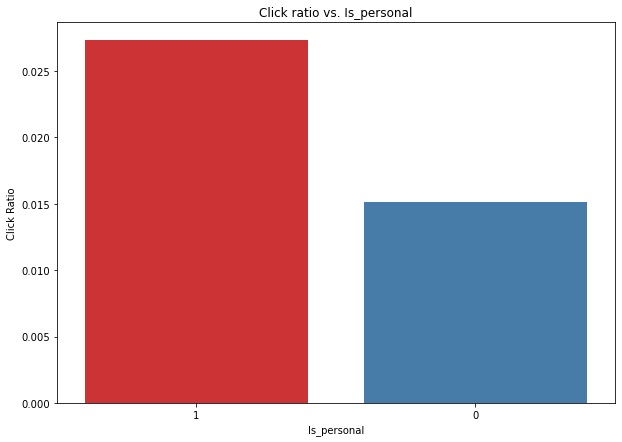

In [15]:
grp_count_plotbar('is_personal')

<span style='color:orange;font-weight:bold;font-size:1.2em'>从图上可以发现，定制的邮件链接点击率会明显高于通用的邮件

### Visualization of `weekday`

Text(0.5, 1.0, 'Open ratio vs. Weekday')

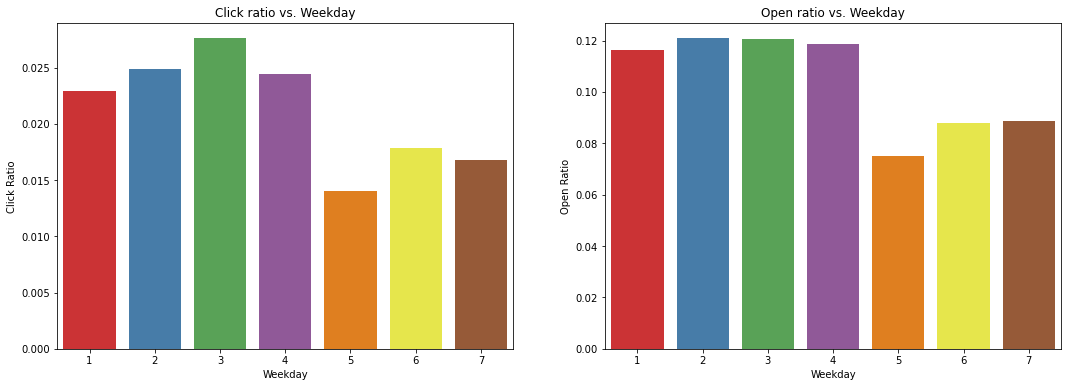

In [16]:
key= 'weekday'
grpresult = emails.groupby(key).apply(count_result_ratio)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(data=grpresult.loc[:,['clicked']].T, palette = "Set1",ax=ax[0])
ax[0].set_xlabel('{}'.format(str.capitalize(key)))
ax[0].set_ylabel("Click Ratio")
ax[0].set_title('Click ratio vs. {}'.format(str.capitalize(key)))

grpresult['total_open']=grpresult['opened']+grpresult['clicked']
sns.barplot(data=grpresult.loc[:,['total_open']].T, palette = "Set1",ax=ax[1])
ax[1].set_xlabel('{}'.format(str.capitalize(key)))
ax[1].set_ylabel("Open Ratio")
ax[1].set_title('Open ratio vs. {}'.format(str.capitalize(key)))

<span style='color:orange;font-weight:bold;font-size:1.2em'>从左图图可以发现，周五到周天发送的邮件链接点击率要明显低于周一到周四，对比右图，我们可以猜测，是因为人们通常不在周五-周天的时间检查邮件

### Visualization of `hour`

Text(0.5, 1.0, 'Open ratio vs. Hour')

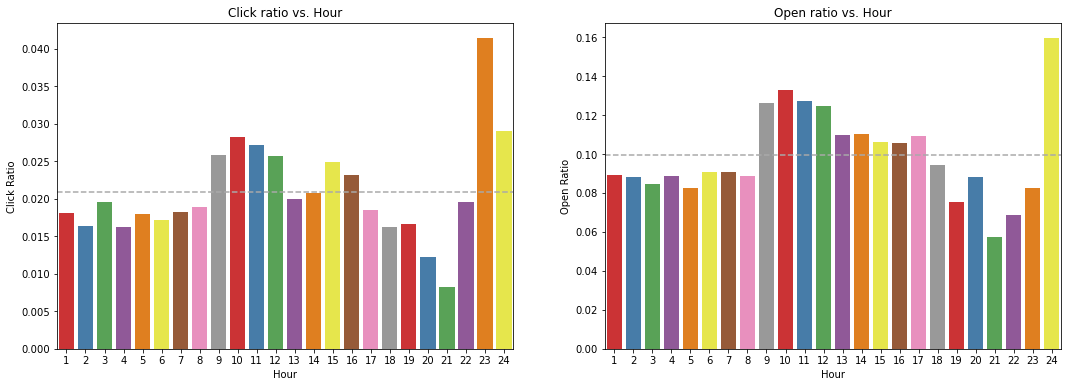

In [18]:
key='hour'
grpresult = emails.groupby(key).apply(count_result_ratio)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(data=grpresult.loc[:,['clicked']].T, palette = "Set1",ax=ax[0])
ax[0].axhline(grpresult.clicked.mean(),color='darkgrey',linestyle='--')
ax[0].set_xlabel('{}'.format(str.capitalize(key)))
ax[0].set_ylabel("Click Ratio")
ax[0].set_title('Click ratio vs. {}'.format(str.capitalize(key)))

grpresult['total_open']=grpresult['opened']+grpresult['clicked']
sns.barplot(data=grpresult.loc[:,['total_open']].T, palette = "Set1",ax=ax[1])
ax[1].axhline(grpresult.total_open.mean(),color='darkgrey',linestyle='--')
ax[1].set_xlabel('{}'.format(str.capitalize(key)))
ax[1].set_ylabel("Open Ratio")
ax[1].set_title('Open ratio vs. {}'.format(str.capitalize(key)))

* <span style='color:orange;font-weight:bold;font-size:1.2em'>上图中灰线分别代表了链接点击率和邮件打开率的平均水平，从左图中我们可以看出9-12，15-16，23-24时间段的连接点击率要略高于平均水平，且在23-24时间段最高</span>
* <span style='color:orange;font-weight:bold;font-size:1.2em'>对比右图中可以看出，一天之中9-17时以及晚上23-24时是人们检查邮件的概率略高，这时间的连接点击率要明显高于其他时间</span>

### Visualization of `paragraph`

response,recived,opened,clicked,total
paragraph,,,,
2,0.883698,0.092430,0.023872,49724.0
4,0.908266,0.073196,0.018538,50276.0


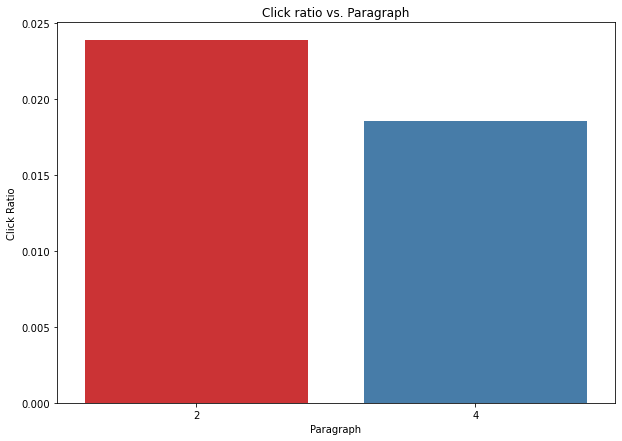

In [19]:
grp_count_plotbar('paragraph')

<span style='color:orange;font-weight:bold;font-size:1.2em'>从上图可以发现，邮件的长度对于链接点击率没有太多的影响</span>

### Visualization of `weekday & hour`

通过对于weekday的分析我们发现，周一到周四与周五到周天的用户行为较为不同，所以我们希望探索一下，是否在两个时间段内每天的行为也有所不同。

Text(0.5, 1.0, 'Open ratio in Fri to Sun')

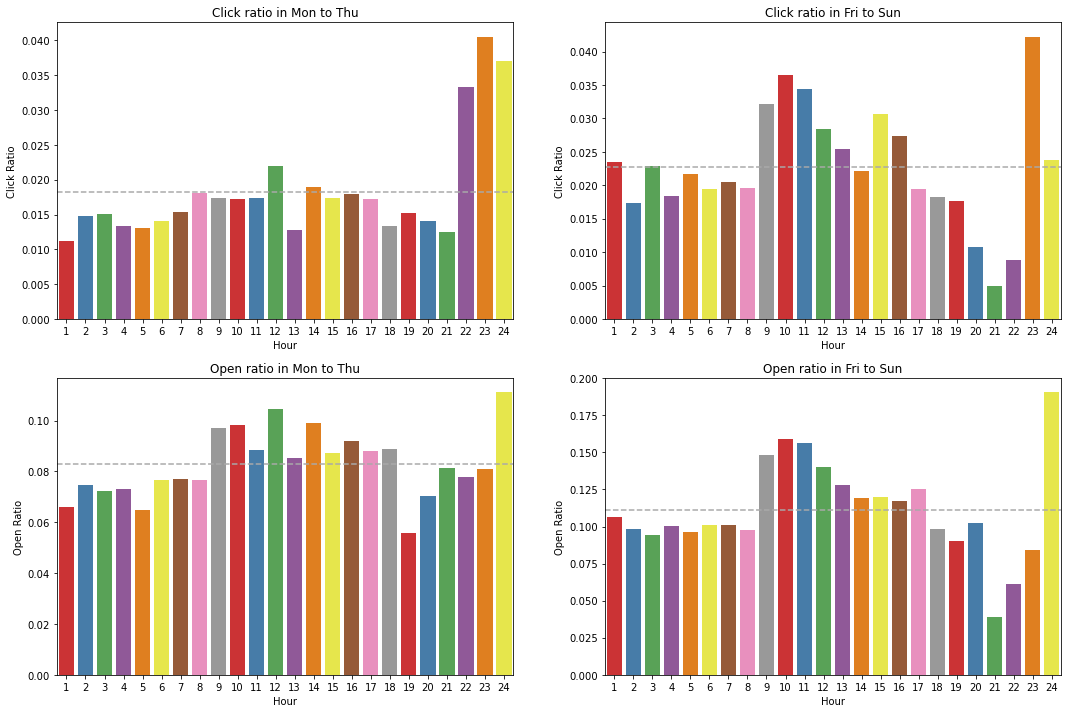

In [21]:
A=emails.copy()
A['weekday_period']=np.where(A['weekday']>4,0,1)
b=A[A['weekday_period']==0]
c=A[A['weekday_period']==1]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
grpresult1 = b.groupby('hour').apply(count_result_ratio)
sns.barplot(data=grpresult1.loc[:,['clicked']].T, palette = "Set1",ax=ax[0][0])
ax[0][0].axhline(grpresult1.clicked.mean(),color='darkgrey',linestyle='--')
ax[0][0].set_xlabel('Hour')
ax[0][0].set_ylabel("Click Ratio")
ax[0][0].set_title('Click ratio in Mon to Thu')

grpresult2 = c.groupby('hour').apply(count_result_ratio)
sns.barplot(data=grpresult2.loc[:,['clicked']].T, palette = "Set1",ax=ax[0][1])
ax[0][1].axhline(grpresult2.clicked.mean(),color='darkgrey',linestyle='--')
ax[0][1].set_xlabel('Hour')
ax[0][1].set_ylabel("Click Ratio")
ax[0][1].set_title('Click ratio in Fri to Sun')

grpresult1['total_open']=grpresult1['opened']+grpresult1['clicked']
sns.barplot(data=grpresult1.loc[:,['total_open']].T, palette = "Set1",ax=ax[1][0])
ax[1][0].axhline(grpresult1.total_open.mean(),color='darkgrey',linestyle='--')
ax[1][0].set_xlabel('Hour')
ax[1][0].set_ylabel("Open Ratio")
ax[1][0].set_title('Open ratio in Mon to Thu')

grpresult2['total_open']=grpresult2['opened']+grpresult2['clicked']
sns.barplot(data=grpresult2.loc[:,['total_open']].T, palette = "Set1",ax=ax[1][1])
ax[1][1].axhline(grpresult2.total_open.mean(),color='darkgrey',linestyle='--')
ax[1][1].set_xlabel('Hour')
ax[1][1].set_ylabel("Open Ratio")
ax[1][1].set_title('Open ratio in Fri to Sun')

* <span style='color:orange;font-weight:bold;font-size:1.2em'>通过对weekday以及hour的特征交叉，我们发现，周一到周四时，用户在9-18时以及24时，查看邮件的概率略高。但是9-18时对应的链接点击率并不高，可能是因为工作时间不太可能查看无关工作的链接，但是对应22-24时的链接点击率要么明显高于其他时间，这说明在周一到周四时间内晚间时间人们更可能点进链接。</span>
* <span style='color:orange;font-weight:bold;font-size:1.2em'>而在周五到周天时间，链接点击率与邮件点开率变化基本一致，即在9-12，15-16，23-24时较高。

## question 3
* <span style='color:blue;font-weight:bold'>Build a model to optimize in future email campaigns to maximize the probability of
users clicking on the link inside the email</span>

In [22]:
# 特征相关性
country_lbencoder=LabelEncoder()
response_lbencoder=LabelEncoder()

X=emails.copy()
y=response_lbencoder.fit_transform(X.response)
del X["response"]

X['country']=country_lbencoder.fit_transform(X.country)
X['weekday_period']=np.where(X['weekday']>4,0,1)
chi2score,_=chi2(X,y)
fscore,_=f_classif(X,y)
feature_scores=pd.DataFrame({"chi2score":chi2score,"fscore":fscore},index=X.columns)

In [23]:
feature_scores.sort_values(by='chi2score',ascending=False)

,chi2score,fscore
purchases,3448.795660,663.388596
country,378.554465,435.696911
is_personal,316.752872,317.427444
weekday,210.006087,105.002643
hour,147.815921,33.992047
weekday_period,142.636188,165.888232
paragraph,53.952439,81.209295


从上述结果中可以发现：
* 重要特征有：purchases、country、is_personal
* 较为不重要的特征有：weekday、hour、paragraph、weekday_period

这一结果与前面的探索性分析结果基本吻合

In [24]:
# 选择特征--因为树模型可以输出特征重要性，所以暂时先将所有的特征选入进行考虑
del X
X=emails.copy()

#目标变量
y=(emails.response=='clicked').astype(np.int_)
X['weekday_period']=np.where(X['weekday']>4,0,1)
X=X.drop(['response','weekday','hour'],axis=1)
#hour根据探索性分析结果进行分桶
#bin=[min(X.hour)-1,8,16,21,24]
#X['hour']=pd.cut(X.hour,bin,labels=['midnight','morning','afternoon','night'])
# One-Hot-Encode country以及hour 特征
#X1 = pd.get_dummies(X,columns=["country","hour"],drop_first=True)
X1 = pd.get_dummies(X,columns=["country"],drop_first=True)

In [25]:
#划分训练集和验证集
X1train,X1test,y1train,y1test = train_test_split(X1,y,test_size=0.25,random_state = 2022)#已处理类别特征

In [26]:
print( 'Train set shape: {}, positive ratio={:.3f}'.format(X1train.shape,y1train.mean()))
print( 'Test set shape: {}, positive ratio={:.3f}'.format(X1test.shape,y1test.mean()))

Train set shape: (75000, 7), positive ratio=0.021
Test set shape: (25000, 7), positive ratio=0.022


### XGBoost

In [27]:
#由于样本严重不均衡，所以评估指标不用准确率采用平均准确率或auc，这里选择auc
param = {'objective': 'binary:logistic',
         'eval_metric': 'auc'
         }
model1=XGBClassifier(**param)
model1.fit(X1train,y1train)
parameters=[{'subsample':[i/10.0 for i in range(6,10,2)],
             'colsample_bytree':[i/10.0 for i in range(6,10,2)],
            'max_depth':[i for i in range(5,10,2)],
            'learning_rate': [0.1, 0.3, 0.6]}]
grid=GridSearchCV(estimator=model1,param_grid=parameters,cv=10,scoring='roc_auc')
grid_search=grid.fit(X1train,y1train)
best_auc=grid_search.best_score_
best_parameters=grid_search.best_params_

In [28]:
best_auc,best_parameters

(0.7341147375544507,
 {'colsample_bytree': 0.6,
  'learning_rate': 0.1,
  'max_depth': 5,
  'subsample': 0.6})

In [29]:
train_matrix = xgb.DMatrix(X1train,y1train)
test_matrix = xgb.DMatrix(X1test)

In [30]:
params={'objective': 'binary:logistic',
        'eval_metric': 'auc',
       'colsample_bytree': 0.6,
       'learning_rate': 0.1,
       'max_depth': 5,
       'subsample': 0.6
         }
seed=2022

params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
params['eta'] = 0.1

cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = seed)

[16:36:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_rounds" } are not used.

[16:36:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_rounds" } are not used.

[16:36:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_rounds" } are not used.

[16:36:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_rounds" } are not used.

[16:36:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba262

In [31]:
n_best_trees = cv_results.shape[0]
print ("best number of trees: {}".format(n_best_trees))

best number of trees: 54


In [32]:
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)

[16:37:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_rounds" } are not used.

[0]	train-auc:0.50000
[1]	train-auc:0.50000
[2]	train-auc:0.66736
[3]	train-auc:0.70052
[4]	train-auc:0.70172
[5]	train-auc:0.70887
[6]	train-auc:0.71731


C:\Users\m1533\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[7]	train-auc:0.71474
[8]	train-auc:0.71777
[9]	train-auc:0.70995
[10]	train-auc:0.71971
[11]	train-auc:0.72238
[12]	train-auc:0.71926
[13]	train-auc:0.72227
[14]	train-auc:0.72463
[15]	train-auc:0.72950
[16]	train-auc:0.73216
[17]	train-auc:0.73345
[18]	train-auc:0.73259
[19]	train-auc:0.73375
[20]	train-auc:0.73336
[21]	train-auc:0.73335
[22]	train-auc:0.73276
[23]	train-auc:0.73316
[24]	train-auc:0.73354
[25]	train-auc:0.73314
[26]	train-auc:0.73367
[27]	train-auc:0.73530
[28]	train-auc:0.73751
[29]	train-auc:0.73979
[30]	train-auc:0.74082
[31]	train-auc:0.74057
[32]	train-auc:0.74083
[33]	train-auc:0.74100
[34]	train-auc:0.74117
[35]	train-auc:0.74071
[36]	train-auc:0.74040
[37]	train-auc:0.74022
[38]	train-auc:0.74036
[39]	train-auc:0.74075
[40]	train-auc:0.74094
[41]	train-auc:0.74121
[42]	train-auc:0.74124
[43]	train-auc:0.74231
[44]	train-auc:0.74314
[45]	train-auc:0.74368
[46]	train-auc:0.74350
[47]	train-auc:0.74337
[48]	train-auc:0.74344
[49]	train-auc:0.74349
[50]	train-auc

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

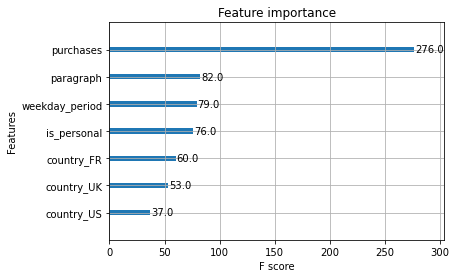

In [33]:
# plot feature importances
xgb.plot_importance(gbt)

In [34]:
print ("n_best_trees={},xgboost parameters: ".format(n_best_trees))
params

n_best_trees=54,xgboost parameters: 


{'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_depth': 5,
 'subsample': 0.6,
 'num_rounds': 300,
 'early_stopping_rounds': 30,
 'eta': 0.1}

In [35]:
#将训练集划分出验证集
def validation_roc():
    Xtrain_only,Xvalid,ytrain_only,yvalid = train_test_split(X1train,y1train,test_size=0.2,random_state=seed)
    
    train_only_matrix = xgb.DMatrix(Xtrain_only,ytrain_only)
    valid_matrix = xgb.DMatrix(Xvalid)
    
    # retrain on training set
    gbt_train_only = xgb.train(params, train_only_matrix, n_best_trees)
    
    # predict on validation set
    yvalid_probas = gbt_train_only.predict(valid_matrix, ntree_limit=n_best_trees)
    
    d = {}
    d['FPR'],d['TPR'],d['Threshold'] = roc_curve(yvalid,yvalid_probas)
    return pd.DataFrame(d)

[16:37:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_rounds" } are not used.



C:\Users\m1533\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Text(0.5, 1.0, 'ROC Curve')

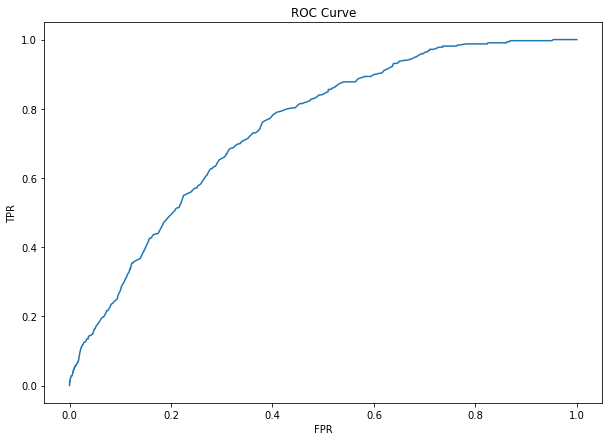

In [36]:
roc_results = validation_roc()
_ = plt.figure(figsize=(10,7))
plt.plot(roc_results.FPR,roc_results.TPR)
plt.xlabel("FPR")
plt.ylabel('TPR')
plt.title('ROC Curve')

In [56]:
#根据图像选择TPR>0.6以及<0.65
roc_results.loc[(roc_results.TPR > 0.6) & (roc_results.TPR < 0.65),:]

,FPR,TPR,Threshold
209,0.270077,0.608150,0.026925
210,0.270213,0.608150,0.026822
211,0.270894,0.608150,0.026758
212,0.274028,0.617555,0.026647
213,0.276616,0.623824,0.026532
214,0.278591,0.626959,0.026478
215,0.280839,0.626959,0.026099
216,0.281180,0.626959,0.025899
217,0.282338,0.630094,0.025802
218,0.285130,0.633229,0.025655


In [54]:
pos_prob_threshold =0.026478
def adjust_predict(matrix):
    y_probas = model1.predict_proba(matrix)
    return (y_probas[:,1] > pos_prob_threshold).astype(int)

ytrain_pred = adjust_predict(X1train)
ytest_pred = adjust_predict(X1test)

In [55]:
print ("test precision: {:.2f}%".format(precision_score(y1test,ytest_pred) * 100))
print ("test recall: {:.2f}%".format(recall_score(y1test,ytest_pred) * 100))

test precision: 4.75%
test recall: 61.98%


## question 4
* <span style='color:blue;font-weight:bold'>By how much do you think your model would improve click through rate ( deﬁned as # of users who click on the link / total users who received the email)</span>

In [41]:
n_emails_old_sent = ytest_pred.shape[0]
n_emails_new_sent = ytest_pred.sum()
saving_percentage = 100 - n_emails_new_sent * 100.0/n_emails_old_sent
pd.Series({'#emails sent in old way': n_emails_old_sent,
           '#emails sent in new way': n_emails_new_sent,
           'saving percentage (%)': saving_percentage})

#emails sent in old way    25000.00
#emails sent in new way     7240.00
saving percentage (%)         71.04
dtype: float64

* <span style='color:orange;'>现模型只需要发送原来邮件总数的30%，但却涵盖了60%可能点击链接的有价值用户.</span>
* <span style='color:orange;'>4.75% 接收到邮件的人会点开链接，是原本概率2.12%的2倍左右. </span> 

<span style='color:blue;font-weight:bold'>How would you test that?</span>

为了验证结论，我需要进行A/B test：
1. 随机将用户分为两组，对照组和实验组。
2. 对照组中，仍然使用旧的电子邮件活动策略，即只向对照组中的所有用户发送电子邮件。
3.在实验组中，用我的模型来预测用户是否会点击链接。并且只向预测结果为阳性的用户发送电子邮件。
4. 然后进行单尾t检验，检验实验组的总体比例是否高于对照组的总体比例。